### ✅ Step 1: Pull Funnel Data from MySQL into Pandas

In [12]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

# Load the raw events log
events_df = pd.read_csv('data/events.csv')

# Preview
events_df.head()


,user_id,event_name,event_timestamp,platform
0,1,app_install,2023-01-01 10:00:00,ios
1,1,app_open,2023-01-01 10:01:00,ios
2,1,view_item,2023-01-01 10:05:00,ios
3,1,add_to_cart,2023-01-01 10:06:00,ios
4,1,purchase,2023-01-01 10:10:00,ios


### 📊 STEP 2: Funnelling Summary with DuckDB SQL

In [13]:
# SQL-like analysis
funnel_query = """
SELECT
    COUNT(DISTINCT CASE WHEN event_name = 'app_install' THEN user_id END) AS install_count,
    COUNT(DISTINCT CASE WHEN event_name = 'signup' THEN user_id END) AS signup_count,
    COUNT(DISTINCT CASE WHEN event_name = 'purchase' THEN user_id END) AS purchase_count
FROM events
"""

funnel_summary = duckdb.query(funnel_query).to_df()
print(funnel_summary)


   install_count  signup_count  purchase_count
0             20             0               5


### 🔁 STEP 3: Daily Active Users (DAU)

C:\Users\user\AppData\Local\Temp\ipykernel_22988\688482358.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\learn-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


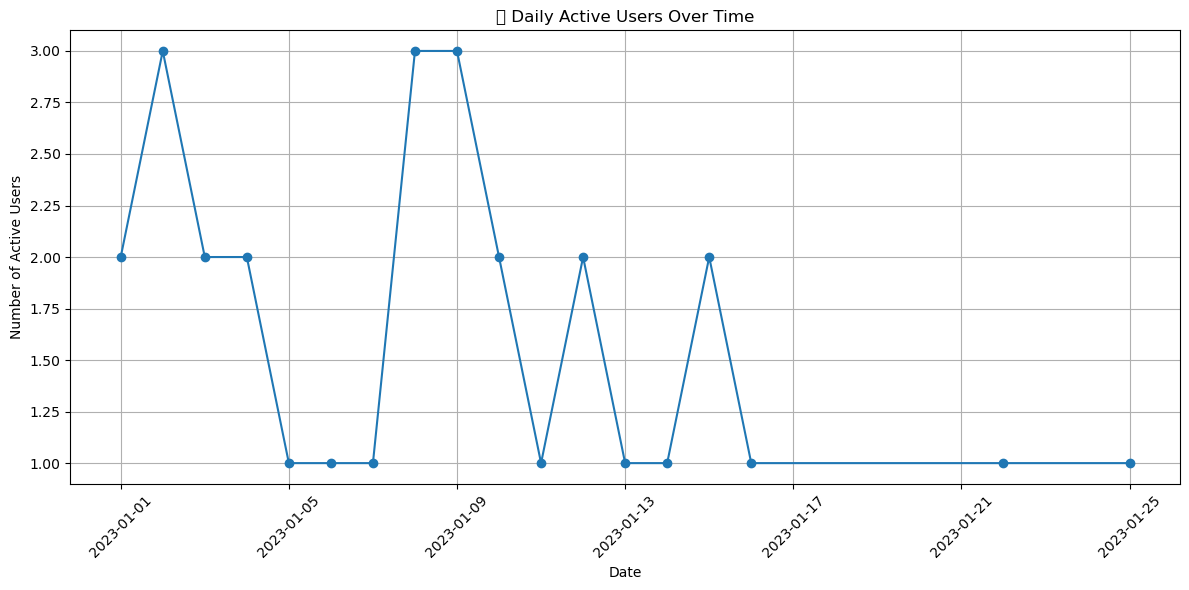

In [14]:
# Convert timestamp to datetime
events['event_timestamp'] = pd.to_datetime(events['event_timestamp'], errors='coerce')

# Calculate Daily Active Users
dau = events.groupby(events['event_timestamp'].dt.date)['user_id'].nunique().reset_index()
dau.columns = ['date', 'daily_active_users']

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dau['date'], dau['daily_active_users'], marker='o')
plt.title('📊 Daily Active Users Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Active Users')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### 🔄 STEP 4: Retention Analysis

C:\Users\user\AppData\Local\Temp\ipykernel_22988\62180566.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=retention, x='day', y='retained_users', palette='Blues_d')
C:\Users\user\AppData\Local\Temp\ipykernel_22988\62180566.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\learn-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


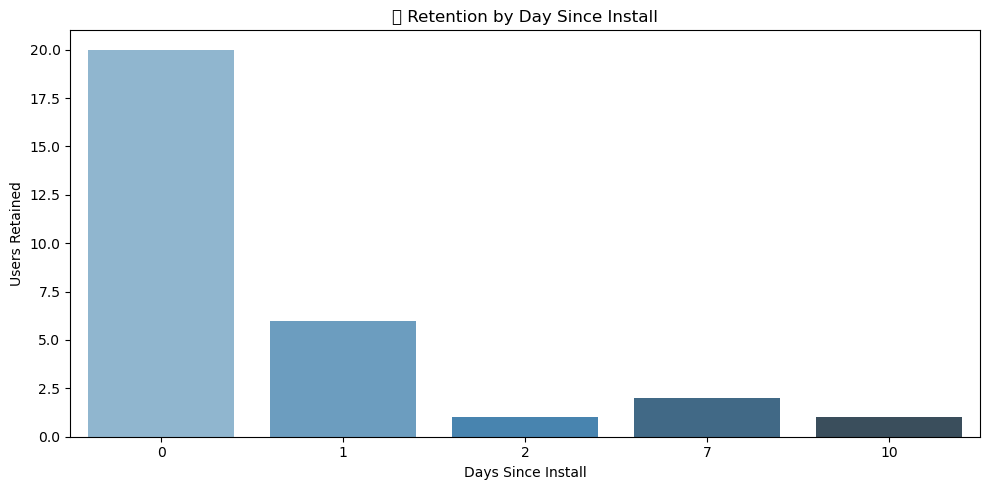

In [15]:
# install date per user
installs = events[events['event_name'] == 'app_install']
installs = installs[['user_id', 'event_timestamp']].rename(columns={'event_timestamp': 'install_time'})

# Merging with all events to calculate days since install
events_with_install = events.merge(installs, on='user_id')
events_with_install['days_since_install'] = (events_with_install['event_timestamp'] - events_with_install['install_time']).dt.days

# Retention: counting users who came back on different days
retention = events_with_install.groupby('days_since_install')['user_id'].nunique().reset_index()
retention.columns = ['day', 'retained_users']


plt.figure(figsize=(10, 5))
sns.barplot(data=retention, x='day', y='retained_users', palette='Blues_d')
plt.title("📊 Retention by Day Since Install")
plt.xlabel("Days Since Install")
plt.ylabel("Users Retained")
plt.tight_layout()
plt.show()


### 🧮 STEP 6: Churn Rate

In [16]:
# Total installs
total_users = installs['user_id'].nunique()

# Users who came back after 1 day
day1_users = retention[retention['day'] == 1]['retained_users'].values[0]

# Churn after day 1
churn_rate = 1 - (day1_users / total_users)
print(f"Churn Rate after Day 1: {churn_rate:.2%}")


Churn Rate after Day 1: 70.00%
